In [20]:
import cv2 
import sys 
import numpy as np 
import pandas as pd
import tensorflow as tf
import albumentations as at 
import matplotlib.pyplot as plt 

In [21]:
from IPython.display import SVG 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical, Sequence, model_to_dot 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.layers import Activation, Dense, Input, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Concatenate
from sklearn.model_selection import train_test_split 

In [22]:
def get_show_version():
    print(f"python : {sys.version}")
    print(f"numpy : {np.__version__}")
    print(f"tensorflow : {tf.__version__}")

def get_show_shape(images):
    for i in range(len(images)):
        print(images[i].shape)

def get_show_plot(images, labels, ncols=15):
    fig, axes = plt.subplots(3 , 5)
    fig.set_size_inches(12, 12)

    for i in range(ncols):
        ax = axes[i//5, i%5]
        ax.imshow(images[i], cmap="gray")
        ax.set_title(str(labels[i]))
        ax.axis("off")        
    plt.tight_layout()
    plt.show()

In [23]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# get_show_version()
# get_show_shape([train_images, train_labels])
# get_show_plot(train_images[:15], train_labels[:15], ncols=15)

In [24]:
def get_preprocessed_images(images, labels):
    images = np.array(images/255., dtype=np.float32)
    lalbes = np.array(labels, dtype=np.float32)

    return images, labels 

def get_preprocessed_one_hot_encoding(images, labels):
    images, labels = get_preprocessed_images(images, labels)
    oh_labels = to_categorical(labels)

    return images, oh_labels 

def get_train_test_valid_separate(train_images, train_labels, test_images, test_labels): 
    train_images, train_oh_labels = get_preprocessed_one_hot_encoding(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_one_hot_encoding(test_images, test_labels)

    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=0.2, random_state=2022)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

def get_odd_even_separate(labels):
    labels_odd = []
    for i in range(len(labels)):
        if np.argmax(labels[i])%2 == 0 :
            labels_odd.append(0)
        else: 
            labels_odd.append(1)
    labels_odd = np.array(labels_odd)

    return labels_odd 

In [25]:
#train_labels_odd = get_odd_even_separate(train_labels)
#test_labels_odd  = get_odd_even_separate(test_labels)
# get_show_shape([train_labels_odd, test_labels_odd])
# get_show_shape([train_labels, test_labels])
# (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels), (tr_odd_labels, val_odd_labels)= get_train_test_valid_separate(train_images, train_labels, test_images, test_labels, train_labels_odd, test_labels_odd)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)= get_train_test_valid_separate(train_images, train_labels, test_images, test_labels)

tr_odd_labels = get_odd_even_separate(tr_oh_labels)
val_odd_labels = get_odd_even_separate(val_oh_labels)
test_odd_labels  = get_odd_even_separate(test_oh_labels)
# train_labels_odd[:15]
# test_labels_odd[:15]
get_show_shape([tr_images, tr_oh_labels,tr_odd_labels, val_images, val_oh_labels, val_odd_labels, test_images, test_oh_labels, test_labels_odd])

(48000, 28, 28)
(48000, 10)
(48000,)
(12000, 28, 28)
(12000, 10)
(12000,)
(10000, 28, 28)
(10000, 10)
(10000,)


In [26]:
IMAGE_SIZE = 28 

In [29]:
def set_create_model():
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="inputs")
    x = Conv2D(filters=32, kernel_size=(3,3))(input_tensor)
    x = Activation("relu")(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)

    flat_x = Flatten()(input_tensor)
    con_x = Concatenate()([x, flat_x])
    digit_output = Dense(10, activation="softmax", name="digit_output")(con_x)
    flat_x = Dense(32, activation="relu")(flat_x)
    odd_output = Dense(1, activation="sigmoid", name="odd_output")(flat_x)
    model = Model(inputs = input_tensor, outputs= [digit_output, odd_output])
    model.summary()

    return model 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 activation_2 (Activation)      (None, 26, 26, 32)   0           ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 32)  0           ['activation_2[0][0]']           
                                                                                            

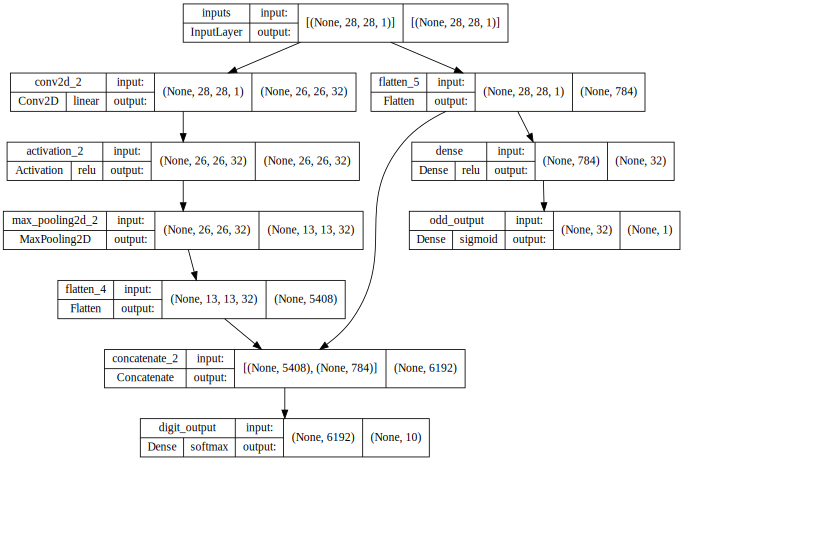

In [30]:
model = set_create_model()
SVG(model_to_dot(model, show_shapes=True, show_layer_activations=True, dpi=60).create(prog="dot", format="svg"))

In [31]:
model.compile(optimizer=Adam(lr=0.001), 
              loss={"digit_output":"categorical_crossentropy", 
                    "odd_output":"binary_crossentropy"},
              loss_weights={"digit_output":1, 
                           "odd_output":0.5},
              metrics = ["accuracy"])

history = model.fit({'inputs': tr_images}, 
                    {'digit_output': tr_oh_labels, 
                     'odd_output': tr_odd_labels}, 
                    validation_data=({'inputs': val_images},  
                                     {'digit_output': val_oh_labels, 'odd_output': val_odd_labels}), 
                    epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3200 - digit_output_loss: 0.2333 - odd_output_loss: 0.1734 - digit_output_accuracy: 0.9338 - odd_output_accuracy: 0.9349 - val_loss: 0.1672 - val_digit_output_loss: 0.1129 - val_odd_output_loss: 0.1087 - val_digit_output_accuracy: 0.9686 - val_odd_output_accuracy: 0.9632
Epoch 2/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1307 - digit_output_loss: 0.0858 - odd_output_loss: 0.0897 - digit_output_accuracy: 0.9750 - odd_output_accuracy: 0.9688 - val_loss: 0.1231 - val_digit_output_loss: 0.0837 - val_odd_output_loss: 0.0788 - val_digit_output_accuracy: 0.9760 - val_odd_output_accuracy: 0.9732
Epoch 3/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0987 - digit_output_loss: 0.0639 - odd_output_loss: 0.0697 - digit_output_accuracy: 0.9812 - odd_output_accuracy: 0.9767 - val_loss: 0.1124 - val_digit_output_loss: 0.0768 - val_odd_output_loss: 0.0712 - val_digit_output_accuracy: 0.

In [32]:
model.evaluate({'inputs': test_images}, {'digit_output': test_oh_labels, 'odd_output': test_odd_labels})

313/313 [==============================] - 1s 4ms/step - loss: 0.1208 - digit_output_loss: 0.0839 - odd_output_loss: 0.0738 - digit_output_accuracy: 0.9806 - odd_output_accuracy: 0.9803


[0.12075904756784439,
 0.08387422561645508,
 0.07376959174871445,
 0.9805999994277954,
 0.9803000092506409]

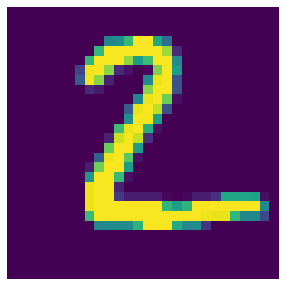

[4.6737302e-12 5.6374740e-13 1.0000000e+00 9.9228105e-11 6.3147015e-22
 1.3499820e-14 5.3335936e-10 2.3615585e-22 8.8607981e-15 5.9687384e-18]
[8.4693655e-11]
[1 0 1 0 0 1 0 1 0 1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [41]:
def get_plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

def get_show_predict(idx):
    digit_predict, odd_predict =  model.predict(test_images)
    print(digit_predict[n_index])
    print(odd_predict[n_index])
    digit_labels = np.argmax(digit_predict, axis=1)
    digit_labels[0:10]
    odd_labels = (odd_predict >0.5).astype(np.int).reshape(1, -1)[0]
    print(odd_labels[0:10])

n_index = 1
get_plot_image(test_images, n_index)
get_show_predict(n_index)
# digit_predict, odd_predict = model.predict(test_images)
# print(digit_predict[n_index])
# print(odd_predict[n_index])
# digit_labels = np.argmax(digit_predict, axis=1)
# digit_labels[0:10]

In [38]:
# odd_labels = (odd_predict >0.5).astype(np.int).reshape(1, -1)[0]
# odd_labels[0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])